使用设备: cuda


Epoch 1/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.63it/s]

Epoch 1, 平均训练损失: 1346.1091


验证集平均损失: 786.9383


Epoch 2/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.73it/s]

Epoch 2, 平均训练损失: 647.1085


验证集平均损失: 574.5211


Epoch 3/20: 100%|██████████| 1272/1272 [01:00<00:00, 20.94it/s]

Epoch 3, 平均训练损失: 547.6305


验证集平均损失: 526.0186


Epoch 4/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.82it/s]

Epoch 4, 平均训练损失: 514.0902


验证集平均损失: 506.1938


Epoch 5/20: 100%|██████████| 1272/1272 [01:00<00:00, 21.15it/s]

Epoch 5, 平均训练损失: 495.2613


验证集平均损失: 489.8530


Epoch 6/20: 100%|██████████| 1272/1272 [01:00<00:00, 21.01it/s]

Epoch 6, 平均训练损失: 477.0072


验证集平均损失: 470.5655


Epoch 7/20: 100%|██████████| 1272/1272 [01:00<00:00, 21.08it/s]

Epoch 7, 平均训练损失: 467.2006


验证集平均损失: 458.3004


Epoch 8/20: 100%|██████████| 1272/1272 [01:00<00:00, 20.87it/s]

Epoch 8, 平均训练损失: 459.0706


验证集平均损失: 460.2347


Epoch 9/20: 100%|██████████| 1272/1272 [01:00<00:00, 21.10it/s]

Epoch 9, 平均训练损失: 453.3806


验证集平均损失: 450.5958


Epoch 10/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.59it/s]

Epoch 10, 平均训练损失: 448.7567


验证集平均损失: 444.0997


Epoch 11/20: 100%|██████████| 1272/1272 [01:00<00:00, 20.87it/s]

Epoch 11, 平均训练损失: 445.2574


验证集平均损失: 444.4643


Epoch 12/20: 100%|██████████| 1272/1272 [01:00<00:00, 20.90it/s]

Epoch 12, 平均训练损失: 441.5987


验证集平均损失: 441.1729


Epoch 13/20: 100%|██████████| 1272/1272 [01:00<00:00, 21.12it/s]

Epoch 13, 平均训练损失: 438.9280


验证集平均损失: 439.6530


Epoch 14/20: 100%|██████████| 1272/1272 [00:59<00:00, 21.45it/s]

Epoch 14, 平均训练损失: 437.0239


验证集平均损失: 435.6238


Epoch 15/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.85it/s]

Epoch 15, 平均训练损失: 434.9279


验证集平均损失: 432.9983


Epoch 16/20: 100%|██████████| 1272/1272 [00:59<00:00, 21.32it/s]

Epoch 16, 平均训练损失: 432.7999


验证集平均损失: 437.2483


Epoch 17/20: 100%|██████████| 1272/1272 [01:00<00:00, 20.97it/s]

Epoch 17, 平均训练损失: 430.9678


验证集平均损失: 427.0375


Epoch 18/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.60it/s]

Epoch 18, 平均训练损失: 429.3357


验证集平均损失: 436.9493


Epoch 19/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.45it/s]

Epoch 19, 平均训练损失: 427.5372


验证集平均损失: 429.8991


Epoch 20/20: 100%|██████████| 1272/1272 [01:00<00:00, 21.00it/s]

Epoch 20, 平均训练损失: 426.1126


验证集平均损失: 429.8740


/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pyl

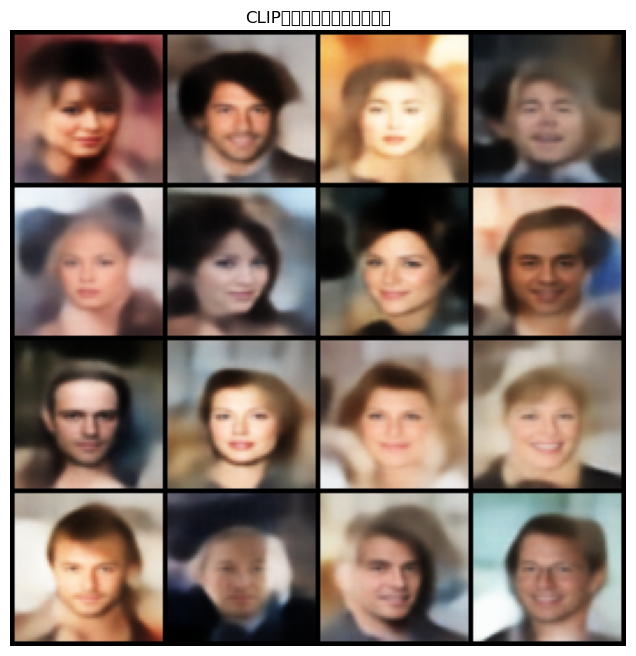

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

# 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载CLIP模型
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# 文本提示词
TEXT_PROMPTS = [
    "A portrait of a young woman",
    "A realistic face with a smile",
    "A person with distinct facial features"
]

# 生成CLIP文本嵌入（提前计算以避免重复计算）
def generate_text_embeddings(text_prompts):
    text_tokens = clip.tokenize(text_prompts).to(device)
    with torch.no_grad():
        text_embeddings = clip_model.encode_text(text_tokens)
    return text_embeddings.cpu()  # 移动到CPU

# 预先计算文本嵌入
CLIP_TEXT_EMBEDDINGS = generate_text_embeddings(TEXT_PROMPTS)

# CelebA数据集类
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, bbox_path, partition_path, 
                 transform=None, partition=0):
        """
        初始化数据集
        :param img_dir: 图像文件夹路径
        :param attr_path: 属性文件路径
        :param bbox_path: 边界框文件路径
        :param partition_path: 分区文件路径
        :param transform: 图像预处理
        :param partition: 使用的数据分区 (0: train, 1: val, 2: test)
        """
        self.img_dir = img_dir
        self.transform = transform

        # 读取属性文件
        attr_df = pd.read_csv(attr_path, sep=',', header=0)
        partition_df = pd.read_csv(partition_path, sep=',', header=0)
        
        # 合并属性文件和分区文件
        attr_df = attr_df.merge(partition_df, on='image_id')
        
        # 根据指定的分区进行筛选
        self.attr_df = attr_df[attr_df['partition'] == partition]
        
        # 读取边界框文件
        bbox_df = pd.read_csv(bbox_path, sep=',', header=0)
        
        # 合并边界框信息
        self.attr_df = self.attr_df.merge(bbox_df, on='image_id')

    def __len__(self):
        return len(self.attr_df)

    def __getitem__(self, idx):
        # 获取图像文件名
        img_name = self.attr_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        
        # 打开图像并转换为RGB
        image = Image.open(img_path).convert('RGB')
        
        # 获取属性标签 
        attrs = self.attr_df.iloc[idx, 1:41].values
        attrs = (attrs + 1) // 2  # 将-1转为0，1保持1
        attrs = attrs.astype(np.float32)
        
        # 应用图像预处理
        if self.transform:
            image = self.transform(image)
        
        # 随机选择一个CLIP文本嵌入
        random_idx = random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)
        clip_embedding = CLIP_TEXT_EMBEDDINGS[random_idx]
        
        return image, attrs, clip_embedding

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128, 
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器部分
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        # 将条件标签、图像和CLIP嵌入拼接
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        # 将潜在变量、条件标签和CLIP嵌入拼接
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 修正归一化
])

# 数据集路径设置（请根据实际路径修改）
img_dir = '/root/autodl-tmp/celeba_datasets/img_align_celeba/img_align_celeba'
attr_path = '/root/autodl-tmp/celeba_datasets/list_attr_celeba.txt'
bbox_path = '/root/autodl-tmp/celeba_datasets/list_bbox_celeba.txt'
partition_path = '/root/autodl-tmp/celeba_datasets/list_eval_partition.txt'

# 创建训练集和验证集
train_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                              transform=transform, partition=0)
val_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                            transform=transform, partition=1)

# 数据加载器
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 初始化模型、损失函数和优化器
latent_dim = 128
cond_dim = 40
clip_dim = 512
model = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                 cond_dim=cond_dim, clip_dim=clip_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='sum')

# 定义损失函数
def loss_function(recon_x, x, mu, logvar):
    recon_loss = criterion(recon_x, x)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KL

# 训练模型
def train_model(model, train_loader, val_loader, optimizer, num_epochs=50):
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, attrs, clip_emb) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")):
            data = data.to(device, non_blocking=True)
            attrs = attrs.to(device, non_blocking=True)
            clip_emb = clip_emb.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, attrs, clip_emb)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        avg_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}, 平均训练损失: {avg_loss:.4f}")
        
        # 验证集评估
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, attrs, clip_emb in val_loader:
                data = data.to(device, non_blocking=True)
                attrs = attrs.to(device, non_blocking=True)
                clip_emb = clip_emb.to(device, non_blocking=True)
                recon_batch, mu, logvar = model(data, attrs, clip_emb)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"验证集平均损失: {avg_val_loss:.4f}")
    
    return model

# 图像生成函数
def generate_images(model, attrs, text_prompts, device, num_images=16):
    """
    根据条件标签和文本提示生成图像
    """
    model.eval()
    
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        attrs = attrs[:num_images].to(device)
        
        # 对于每个图像随机选择一个文本嵌入
        text_embeddings = torch.stack([
            CLIP_TEXT_EMBEDDINGS[random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)] 
            for _ in range(num_images)
        ]).to(device)
        
        generated = model.decode(z, attrs, text_embeddings)
        generated = generated.cpu()
        return generated

# 训练模型
trained_model = train_model(model, train_loader, val_loader, optimizer, num_epochs=20)

# 保存模型
torch.save(trained_model.state_dict(), 'clip_cvae_celeba.pth')

# 生成图像示例
data_iter = iter(val_loader)
images, attrs, _ = next(data_iter)
sample_attrs = attrs[:16]

generated_images = generate_images(trained_model, sample_attrs, TEXT_PROMPTS, device, num_images=16)

# 可视化生成的图像
def show_images(images, title="Generated Images"):
    images = images * 0.5 + 0.5  # 反归一化
    grid = torchvision.utils.make_grid(images, nrow=4)
    np_grid = grid.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

show_images(generated_images, title="CLIP引导的条件生成人脸图像")


## 利用映射网络生成的图像凑活能看

使用设备: cuda
CLIP模型已加载。
ClipCVAE模型已加载并转换为 float32。
TextToImageEmbedder模型已加载并转换为 float32。


/tmp/ipykernel_6844/3014226996.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvae.load_state_dict(torch.load('clip_cvae_celeba.pth', map_location=device))
/tmp/ipyke

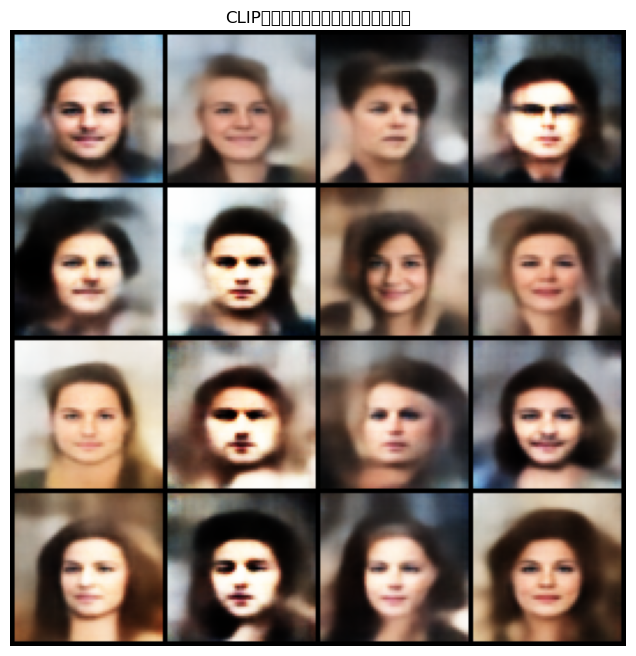

/tmp/ipykernel_6844/3014226996.py:332: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  validation_text_embeddings = torch.load(VALIDATION_TEXT_EMBEDDINGS_PATH)
/tmp/ipykernel_

验证集映射嵌入与真实嵌入的平均余弦相似度: 0.8290


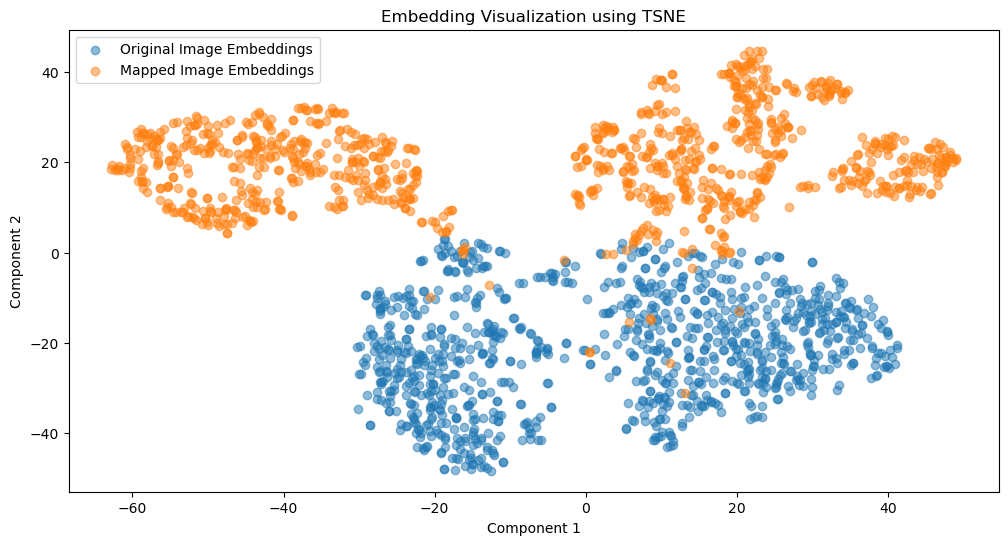

In [24]:
import os
import torch
import torch.nn as nn
import clip
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import numpy as np

# ------------------------ #
# 1. 设备设置
# ------------------------ #

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ------------------------ #
# 2. 加载CLIP模型
# ------------------------ #

clip_model, preprocess_clip = clip.load("ViT-B/32", device=device)
clip_model.eval()
print("CLIP模型已加载。")

# ------------------------ #
# 3. 定义ClipCVAE模型
# ------------------------ #

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128, 
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

latent_dim = 128
cond_dim = 40
clip_dim = 512
cvae = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
               cond_dim=cond_dim, clip_dim=clip_dim).to(device)
cvae.load_state_dict(torch.load('clip_cvae_celeba.pth', map_location=device))
cvae = cvae.float()
cvae.eval()
print("ClipCVAE模型已加载并转换为 float32。")

# ------------------------ #
# 4. 定义TextToImageEmbedder模型
# ------------------------ #
# 请确保此结构与您训练text_to_image_embedder.pth时使用的结构一致
# 定义优化后的映射网络模型
class TextToImageEmbedder(nn.Module):
    def __init__(self, clip_dim=512, embed_dim=512):
        super(TextToImageEmbedder, self).__init__()
        self.mapping = nn.Sequential(
            nn.Linear(clip_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, embed_dim),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
    
    def forward(self, text_embeddings):
        image_embeddings = self.mapping(text_embeddings)
        return image_embeddings

embedder = TextToImageEmbedder(clip_dim=512, embed_dim=512).to(device)
embedder.load_state_dict(torch.load('text_to_image_embedder.pth', map_location=device), strict=True)
embedder = embedder.float()
embedder.eval()
print("TextToImageEmbedder模型已加载并转换为 float32。")

# ------------------------ #
# 5. 定义属性标签映射函数
# ------------------------ #

def get_attributes_from_prompt(prompt):
    attrs = torch.zeros(40).float()
    attr_dict = {
        '5_o_Clock_Shadow': 1,
        'Arched_Eyebrows': 2,
        'Attractive': 3,
        'Bags_Under_Eyes': 4,
        'Bald': 5,
        'Bangs': 6,
        'Big_Lips': 7,
        'Big_Nose': 8,
        'Black_Hair': 9,
        'Blond_Hair': 10,
        'Blurry': 11,
        'Brown_Hair': 12,
        'Bushy_Eyebrows': 13,
        'Chubby': 14,
        'Double_Chin': 15,
        'Eyeglasses': 16,
        'Goatee': 17,
        'Gray_Hair': 18,
        'Heavy_Makeup': 19,
        'High_Cheekbones': 20,
        'Male': 21,
        'Mouth_Slightly_Open': 22,
        'Mustache': 23,
        'Narrow_Eyes': 24,
        'No_Beard': 25,
        'Oval_Face': 26,
        'Pale_Skin': 27,
        'Pointy_Nose': 28,
        'Receding_Hairline': 29,
        'Rosy_Cheeks': 30,
        'Sideburns': 31,
        'Smiling': 32,
        'Straight_Hair': 33,
        'Wavy_Hair': 34,
        'Wearing_Earrings': 35,
        'Wearing_Hat': 36,
        'Wearing_Lipstick': 37,
        'Wearing_Necklace': 38,
        'Wearing_Necktie': 39,
        'Young': 40
    }

    keyword_attr_map = {
        'shadow': '5_o_Clock_Shadow',
        'arched eyebrows': 'Arched_Eyebrows',
        'attractive': 'Attractive',
        'bags under eyes': 'Bags_Under_Eyes',
        'bald': 'Bald',
        'bangs': 'Bangs',
        'big lips': 'Big_Lips',
        'big nose': 'Big_Nose',
        'black hair': 'Black_Hair',
        'blond hair': 'Blond_Hair',
        'blurry': 'Blurry',
        'brown hair': 'Brown_Hair',
        'bushy eyebrows': 'Bushy_Eyebrows',
        'chubby': 'Chubby',
        'double chin': 'Double_Chin',
        'eyeglasses': 'Eyeglasses',
        'goatee': 'Goatee',
        'gray hair': 'Gray_Hair',
        'heavy makeup': 'Heavy_Makeup',
        'high cheekbones': 'High_Cheekbones',
        'male': 'Male',
        'mouth slightly open': 'Mouth_Slightly_Open',
        'mustache': 'Mustache',
        'narrow eyes': 'Narrow_Eyes',
        'no beard': 'No_Beard',
        'oval face': 'Oval_Face',
        'pale skin': 'Pale_Skin',
        'pointy nose': 'Pointy_Nose',
        'receding hairline': 'Receding_Hairline',
        'rosy cheeks': 'Rosy_Cheeks',
        'sideburns': 'Sideburns',
        'smiling': 'Smiling',
        'straight hair': 'Straight_Hair',
        'wavy hair': 'Wavy_Hair',
        'wearing earrings': 'Wearing_Earrings',
        'wearing hat': 'Wearing_Hat',
        'wearing lipstick': 'Wearing_Lipstick',
        'wearing necklace': 'Wearing_Necklace',
        'wearing necktie': 'Wearing_Necktie',
        'young': 'Young'
    }

    prompt = prompt.lower()
    for keyword, attr in keyword_attr_map.items():
        if keyword in prompt:
            attr_index = attr_dict[attr]
            attrs[attr_index - 1] = 1
    return attrs

def compute_cosine_similarity(mapped_embeddings, actual_embeddings):
    cos = nn.CosineSimilarity(dim=1)
    similarity = cos(mapped_embeddings, actual_embeddings)
    return similarity.mean().item()

def visualize_embeddings(original_emb, mapped_emb, num_samples=1000, method='tsne'):
    original_emb = original_emb[:num_samples].cpu().numpy()
    mapped_emb = mapped_emb[:num_samples].cpu().numpy()

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=2)

    combined = np.vstack((original_emb, mapped_emb))
    reduced = reducer.fit_transform(combined)

    plt.figure(figsize=(12, 6))
    plt.scatter(reduced[:num_samples, 0], reduced[:num_samples, 1], label='Original Image Embeddings', alpha=0.5)
    plt.scatter(reduced[num_samples:, 0], reduced[num_samples:, 1], label='Mapped Image Embeddings', alpha=0.5)
    plt.legend()
    plt.title(f"Embedding Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

def generate_images_from_text(text_prompts, model_cvae, model_embedder, clip_model, device, 
                             img_size=64, cond_dim=40, latent_dim=128, num_images=16):
    with torch.no_grad():
        text_tokens = clip.tokenize(text_prompts).to(device)
        text_embeddings = clip_model.encode_text(text_tokens).float()
        mapped_image_embeddings = model_embedder(text_embeddings)
        z = torch.randn(num_images, latent_dim).to(device)
        attrs = torch.stack([get_attributes_from_prompt(prompt) for prompt in text_prompts]).to(device)
        if len(text_prompts) != num_images:
            raise ValueError("文本描述的数量应与要生成的图像数量一致。")
        generated_imgs = model_cvae.decode(z, attrs, mapped_image_embeddings)
        return generated_imgs

def show_images(images, title="Generated Images", nrow=4):
    images = images * 0.5 + 0.5
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    np_grid = grid.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    text_prompts = [
        "A portrait of a young woman with a smile",
        "A realistic face with a smile",
        "A person with distinct facial features",
        "A portrait of a middle-aged man with glasses",
        "A happy elderly woman",
        "A young man with a beard",
        "A smiling person with dark hair",
        "A person with blue eyes and a pleasant expression",
        "A cheerful young woman with long hair",
        "A man with a serious look",
        "A woman with a stylish haircut",
        "A person with a friendly smile",
        "A portrait of a person with freckles",
        "A young person with bright eyes",
        "A person with a confident expression",
        "A portrait of a person with curly hair"
    ]

    num_images = len(text_prompts)

    try:
        generated_images = generate_images_from_text(
            text_prompts, cvae, embedder, clip_model, device, 
            img_size=64, cond_dim=40, latent_dim=128, num_images=num_images
        )
    except Exception as e:
        print(f"图像生成过程中出现错误: {e}")
        raise

    show_images(generated_images, title="CLIP映射网络引导的条件生成人脸图像", nrow=4)

    VALIDATION_TEXT_EMBEDDINGS_PATH = '/root/autodl-tmp/clip_embeddings/text_embeddings_partition_1.pt'
    VALIDATION_IMAGE_EMBEDDINGS_PATH = '/root/autodl-tmp/clip_embeddings/image_embeddings_partition_1.pt'

    try:
        validation_text_embeddings = torch.load(VALIDATION_TEXT_EMBEDDINGS_PATH)
        validation_image_embeddings = torch.load(VALIDATION_IMAGE_EMBEDDINGS_PATH)
    except Exception as e:
        print(f"Error loading validation embeddings: {e}")
        raise

    assert len(validation_text_embeddings) == len(validation_image_embeddings), "验证集文本和图像嵌入的数量不匹配"

    validation_text_embeddings = validation_text_embeddings.to(device).float()
    validation_image_embeddings = validation_image_embeddings.to(device).float()

    with torch.no_grad():
        mapped_validation_image_embeddings = embedder(validation_text_embeddings)

    similarity = compute_cosine_similarity(mapped_validation_image_embeddings, validation_image_embeddings)
    print(f"验证集映射嵌入与真实嵌入的平均余弦相似度: {similarity:.4f}")

    visualize_embeddings(validation_image_embeddings, mapped_validation_image_embeddings, num_samples=1000, method='tsne')


## 利用生成好的图像嵌入训练和测试有一版本

使用设备: cuda
CLIP模型已加载。
Attributes DataFrame columns: ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Attributes DataFrame head:
      image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   

/tmp/ipykernel_6844/2787256917.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.image_embeddings = torch.load(image_embeddings_path)  # 假设是一个Tensor，shape=(num_imag

Attributes DataFrame columns: ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Attributes DataFrame head:
      image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg        

/tmp/ipykernel_6844/2787256917.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.image_embeddings = torch.load(image_embeddings_path)  # 假设是一个Tensor，shape=(num_imag

After merging with bounding box, columns: ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'partition', 'x_1', 'y_1', 'width', 'height']
Final Merged DataFrame head:
      image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1           

Epoch 1/20: 100%|██████████| 1272/1272 [01:19<00:00, 15.97it/s]


Epoch 1, 平均训练损失: 1263.3880
验证集平均损失: 754.3533


Epoch 2/20: 100%|██████████| 1272/1272 [01:22<00:00, 15.46it/s]

Epoch 2, 平均训练损失: 674.8839


验证集平均损失: 617.2999


Epoch 3/20: 100%|██████████| 1272/1272 [01:16<00:00, 16.65it/s]

Epoch 3, 平均训练损失: 582.7569


验证集平均损失: 550.6537


Epoch 4/20: 100%|██████████| 1272/1272 [01:19<00:00, 15.94it/s]

Epoch 4, 平均训练损失: 521.5583


验证集平均损失: 490.9672


Epoch 5/20: 100%|██████████| 1272/1272 [01:17<00:00, 16.34it/s]

Epoch 5, 平均训练损失: 492.7868


验证集平均损失: 477.0281


Epoch 6/20: 100%|██████████| 1272/1272 [01:20<00:00, 15.85it/s]

Epoch 6, 平均训练损失: 475.8224


验证集平均损失: 470.4273


Epoch 7/20: 100%|██████████| 1272/1272 [01:20<00:00, 15.77it/s]

Epoch 7, 平均训练损失: 461.7238


验证集平均损失: 450.5452


Epoch 8/20: 100%|██████████| 1272/1272 [01:18<00:00, 16.27it/s]

Epoch 8, 平均训练损失: 456.2729


验证集平均损失: 455.1782


Epoch 9/20: 100%|██████████| 1272/1272 [01:20<00:00, 15.81it/s]

Epoch 9, 平均训练损失: 446.8708


验证集平均损失: 442.5255


Epoch 10/20: 100%|██████████| 1272/1272 [01:17<00:00, 16.31it/s]

Epoch 10, 平均训练损失: 439.2762


验证集平均损失: 439.4471


Epoch 11/20: 100%|██████████| 1272/1272 [01:17<00:00, 16.45it/s]

Epoch 11, 平均训练损失: 435.3185


验证集平均损失: 434.5953


Epoch 12/20: 100%|██████████| 1272/1272 [01:19<00:00, 16.10it/s]

Epoch 12, 平均训练损失: 430.6354


验证集平均损失: 431.0584


Epoch 13/20: 100%|██████████| 1272/1272 [01:17<00:00, 16.42it/s]

Epoch 13, 平均训练损失: 447.1005


验证集平均损失: 432.8380


Epoch 14/20: 100%|██████████| 1272/1272 [01:20<00:00, 15.79it/s]

Epoch 14, 平均训练损失: 428.1554


验证集平均损失: 428.6398


Epoch 15/20: 100%|██████████| 1272/1272 [01:17<00:00, 16.50it/s]

Epoch 15, 平均训练损失: 422.8054


验证集平均损失: 425.4788


Epoch 16/20: 100%|██████████| 1272/1272 [01:17<00:00, 16.33it/s]

Epoch 16, 平均训练损失: 437.0279


验证集平均损失: 467.6483


Epoch 17/20: 100%|██████████| 1272/1272 [01:19<00:00, 16.02it/s]

Epoch 17, 平均训练损失: 436.0588


验证集平均损失: 428.6444


Epoch 18/20: 100%|██████████| 1272/1272 [01:17<00:00, 16.50it/s]

Epoch 18, 平均训练损失: 421.8358


验证集平均损失: 424.3285


Epoch 19/20: 100%|██████████| 1272/1272 [01:21<00:00, 15.70it/s]

Epoch 19, 平均训练损失: 419.5596


验证集平均损失: 423.5742


Epoch 20/20: 100%|██████████| 1272/1272 [01:18<00:00, 16.21it/s]

Epoch 20, 平均训练损失: 415.3479


验证集平均损失: 422.2676
ClipCVAE模型已保存为: clip_cvae_celeba.pth


/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pyl

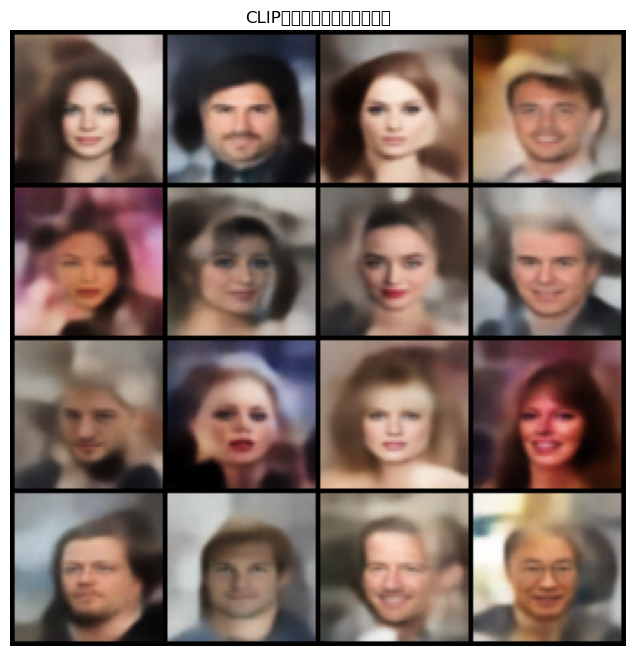

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

# ------------------------ #
# 1. 设备设置
# ------------------------ #

# 选择设备（GPU或CPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ------------------------ #
# 2. 加载CLIP模型
# ------------------------ #

# 加载CLIP模型和预处理方法
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
print("CLIP模型已加载。")

# ------------------------ #
# 3. 定义CelebA数据集类
# ------------------------ #

class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, bbox_path, partition_path, 
                 image_embeddings_path, transform=None, partition=0):
        """
        初始化数据集
        :param img_dir: 图像文件夹路径
        :param attr_path: 属性文件路径
        :param bbox_path: 边界框文件路径
        :param partition_path: 分区文件路径
        :param image_embeddings_path: 预先计算的图像嵌入文件路径
        :param transform: 图像预处理
        :param partition: 使用的数据分区 (0: train, 1: val, 2: test)
        """
        self.img_dir = img_dir
        self.transform = transform

        # 读取属性文件
        try:
            attr_df = pd.read_csv(attr_path, sep=',', header=0)
        except Exception as e:
            print(f"Error reading {attr_path}: {e}")
            raise

        print("Attributes DataFrame columns:", attr_df.columns.tolist())
        print("Attributes DataFrame head:\n", attr_df.head())

        # 确认 'image_id' 列存在
        if 'image_id' not in attr_df.columns:
            raise ValueError("属性文件中缺少 'image_id' 列。请检查文件格式。")
        else:
            print("'image_id' column found in attributes DataFrame.")

        # 读取分区文件
        try:
            partition_df = pd.read_csv(partition_path, sep=',', header=0, names=['image_id', 'partition'])
        except Exception as e:
            print(f"Error reading {partition_path}: {e}")
            raise

        print("Partition DataFrame columns:", partition_df.columns.tolist())
        print("Partition DataFrame head:\n", partition_df.head())

        # 读取边界框文件
        try:
            bbox_df = pd.read_csv(bbox_path, sep=',', header=0, names=['image_id', 'x_1', 'y_1', 'width', 'height'])
        except Exception as e:
            print(f"Error reading {bbox_path}: {e}")
            raise

        print("Bounding Box DataFrame columns:", bbox_df.columns.tolist())
        print("Bounding Box DataFrame head:\n", bbox_df.head())

        # 合并属性和分区数据
        try:
            attr_df = attr_df.merge(partition_df, on='image_id')
        except Exception as e:
            print(f"Error merging attributes and partitions: {e}")
            raise

        print("After merging with partition, columns:", attr_df.columns.tolist())
        print("Merged DataFrame head:\n", attr_df.head())

        # 合并属性、分区和边界框数据
        try:
            attr_df = attr_df.merge(bbox_df, on='image_id')
        except Exception as e:
            print(f"Error merging attributes, partitions and bounding boxes: {e}")
            raise

        print("After merging with bounding box, columns:", attr_df.columns.tolist())
        print("Final Merged DataFrame head:\n", attr_df.head())

        # 筛选分区
        print(f"Total samples before filtering: {len(attr_df)}")
        self.attr_df = attr_df[attr_df['partition'] == partition].reset_index(drop=True)
        print(f"Total samples after filtering partition {partition}: {len(self.attr_df)}")

        if len(self.attr_df) == 0:
            raise ValueError(f"训练集中没有样本。请检查数据文件的读取和过滤逻辑。")

        # 获取属性名称
        # 属性列是除了 'image_id', 'partition', 'x_1', 'y_1', 'width', 'height' 之外的所有列
        self.attr_names = [col for col in attr_df.columns if col not in ['image_id', 'partition', 'x_1', 'y_1', 'width', 'height']]
        print("Attribute names:", self.attr_names)

        # 加载预计算的图像嵌入
        self.image_embeddings = torch.load(image_embeddings_path)  # 假设是一个Tensor，shape=(num_images, 512)
        if len(self.image_embeddings) != len(self.attr_df):
            raise ValueError("图像嵌入的数量与数据集中的图像数量不一致。")
        self.image_embeddings = self.image_embeddings.float()

    def __len__(self):
        return len(self.attr_df)

    def __getitem__(self, idx):
        # 获取图像路径
        img_name = self.attr_df.iloc[idx, self.attr_df.columns.get_loc('image_id')]
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
            # 可以选择跳过该样本，或返回一个默认图像
            # 这里选择抛出异常
            raise

        if self.transform:
            image = self.transform(image)

        # 获取属性标签 
        attrs = self.attr_df.iloc[idx][self.attr_names].values
        attrs = (attrs + 1) // 2  # 将-1转为0，1保持1
        attrs = attrs.astype(np.float32)

        # 获取对应的图像嵌入
        clip_embedding = self.image_embeddings[idx]

        return image, attrs, clip_embedding

# ------------------------ #
# 4. 定义ClipCVAE模型
# ------------------------ #

class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128, 
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器部分
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        # 将条件标签、图像和CLIP嵌入拼接
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        # 将潜在变量、条件标签和CLIP嵌入拼接
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar

# ------------------------ #
# 5. 图像预处理
# ------------------------ #

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 修正归一化
])

# ------------------------ #
# 6. 数据集路径设置
# ------------------------ #

# 请根据实际路径修改
img_dir = '/root/autodl-tmp/celeba_datasets/img_align_celeba/img_align_celeba'
attr_path = '/root/autodl-tmp/celeba_datasets/list_attr_celeba.txt'
bbox_path = '/root/autodl-tmp/celeba_datasets/list_bbox_celeba.txt'
partition_path = '/root/autodl-tmp/celeba_datasets/list_eval_partition.txt'
image_embeddings_train_path = '/root/autodl-tmp/clip_embeddings/image_embeddings_partition_0.pt'
image_embeddings_val_path = '/root/autodl-tmp/clip_embeddings/image_embeddings_partition_1.pt'

# ------------------------ #
# 7. 创建训练集和验证集
# ------------------------ #

train_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                              image_embeddings_train_path, transform=transform, partition=0)
val_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                            image_embeddings_val_path, transform=transform, partition=1)

# ------------------------ #
# 8. 数据加载器
# ------------------------ #

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# ------------------------ #
# 9. 初始化模型、损失函数和优化器
# ------------------------ #

latent_dim = 128
cond_dim = 40
clip_dim = 512
model = ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                cond_dim=cond_dim, clip_dim=clip_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='sum')

# ------------------------ #
# 10. 定义损失函数
# ------------------------ #

def loss_function(recon_x, x, mu, logvar):
    recon_loss = criterion(recon_x, x)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KL

# ------------------------ #
# 11. 训练模型
# ------------------------ #

def train_model(model, train_loader, val_loader, optimizer, num_epochs=50):
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, attrs, clip_emb) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")):
            data = data.to(device, non_blocking=True)
            attrs = attrs.to(device, non_blocking=True)
            clip_emb = clip_emb.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, attrs, clip_emb)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        avg_loss = train_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}, 平均训练损失: {avg_loss:.4f}")
        
        # 验证集评估
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, attrs, clip_emb in val_loader:
                data = data.to(device, non_blocking=True)
                attrs = attrs.to(device, non_blocking=True)
                clip_emb = clip_emb.to(device, non_blocking=True)
                recon_batch, mu, logvar = model(data, attrs, clip_emb)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        print(f"验证集平均损失: {avg_val_loss:.4f}")
    
    return model

# ------------------------ #
# 12. 图像生成函数
# ------------------------ #

def generate_images(model, attrs, image_embeddings, device, num_images=16):
    """
    根据条件标签和图像嵌入生成图像
    :param model: 训练好的ClipCVAE模型
    :param attrs: 条件标签张量，shape=(num_images, 40)
    :param image_embeddings: 图像嵌入张量，shape=(num_images, 512)
    :param device: 设备（GPU或CPU）
    :param num_images: 生成图像的数量
    :return: 生成的图像张量
    """
    model.eval()
    
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        attrs = attrs[:num_images].to(device)
        image_embeddings = image_embeddings[:num_images].to(device)
        
        generated = model.decode(z, attrs, image_embeddings)
        generated = generated.cpu()
        return generated

# ------------------------ #
# 13. 可视化函数
# ------------------------ #

def show_images(images, title="Generated Images"):
    """
    显示生成的图像网格。
    :param images: 生成的图像张量。
    :param title: 图像网格的标题。
    """
    images = images * 0.5 + 0.5  # 反归一化
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=4)
    np_grid = grid.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# ------------------------ #
# 14. 主程序
# ------------------------ #

if __name__ == "__main__":
    # 训练模型
    trained_model = train_model(model, train_loader, val_loader, optimizer, num_epochs=20)
    
    # 保存模型
    torch.save(trained_model.state_dict(), 'clip_cvae_celeba.pth')
    print("ClipCVAE模型已保存为: clip_cvae_celeba.pth")
    
    # 生成图像示例
    data_iter = iter(val_loader)
    try:
        images, attrs, image_embeddings = next(data_iter)
    except StopIteration:
        raise ValueError("验证集中没有数据。")
    
    sample_attrs = attrs[:16]
    sample_image_embeddings = image_embeddings[:16]
    
    generated_images = generate_images(trained_model, sample_attrs, sample_image_embeddings, device, num_images=16)
    
    # 可视化生成的图像
    show_images(generated_images, title="CLIP引导的条件生成人脸图像")
